In [ ]:
!pip uninstall -y numpy scipy scikit-learn tensorflow


Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0


In [ ]:
!pip install numpy==1.23.5 scipy==1.10.1 scikit-learn==1.2.2 tensorflow==2.12.0 --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
blosc2 3.4.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
bigframes 2.6.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-le

In [ ]:
!pip install segmentation-models tensorflow albumentations scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requi

In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.7.0
!pip install segmentation-models albumentations scikit-learn


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
ERROR: Could not find a version that satisfies the requirement tensorflow==2.7.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.7.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
#unet++
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, jaccard_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import albumentations as A

# === Load BUSI Dataset ===
def load_busi_data(base_path, img_size=(256, 256)):
    X, Y = [], []
    for cls in ['benign', 'malignant']:
        path = os.path.join(base_path, cls)
        files = glob(os.path.join(path, '*.png'))
        for img_path in files:
            if '_mask' in img_path:
                continue
            mask_path = img_path.replace('.png', '_mask.png')
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if img is None or mask is None:
                continue
            img = cv2.resize(img, img_size) / 255.0
            mask = cv2.resize(mask, img_size) / 255.0
            mask = (mask > 0.5).astype(np.uint8)
            X.append(np.expand_dims(img, -1))
            Y.append(np.expand_dims(mask, -1))
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.uint8)

# === Data Augmentation ===
def augment(X, Y, n_aug=2):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.2), A.Rotate(limit=20, p=0.5),
        A.RandomBrightnessContrast(p=0.5), A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.ElasticTransform(alpha=1, sigma=50, p=0.3), A.GridDistortion(p=0.3)
    ])
    X_aug, Y_aug = [], []
    for i in range(len(X)):
        for _ in range(n_aug):
            img = (X[i].squeeze() * 255).astype(np.uint8)
            mask = (Y[i].squeeze() * 255).astype(np.uint8)
            augmented = transform(image=img, mask=mask)
            img_aug = augmented['image'].astype(np.float32) / 255.0
            mask_aug = (augmented['mask'] > 127).astype(np.uint8)
            X_aug.append(np.expand_dims(img_aug, -1))
            Y_aug.append(np.expand_dims(mask_aug, -1))
    return np.array(X_aug), np.array(Y_aug)

# === Build U-Net++ ===
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def build_unetpp(input_shape=(256, 256, 1)):
    inputs = layers.Input(input_shape)
    x0_0 = conv_block(inputs, 64)
    x1_0 = conv_block(layers.MaxPooling2D()(x0_0), 128)
    x2_0 = conv_block(layers.MaxPooling2D()(x1_0), 256)
    x3_0 = conv_block(layers.MaxPooling2D()(x2_0), 512)
    x4_0 = conv_block(layers.MaxPooling2D()(x3_0), 1024)
    x3_1 = conv_block(layers.concatenate([x3_0, layers.UpSampling2D()(x4_0)]), 512)
    x2_2 = conv_block(layers.concatenate([x2_0, layers.UpSampling2D()(x3_1)]), 256)
    x1_3 = conv_block(layers.concatenate([x1_0, layers.UpSampling2D()(x2_2)]), 128)
    x0_4 = conv_block(layers.concatenate([x0_0, layers.UpSampling2D()(x1_3)]), 64)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x0_4)
    return models.Model(inputs, outputs)

# === Loss & Metrics ===
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# === Training ===
data_path = "/content/Dataset_BUSI_with_GT"
X, Y = load_busi_data(data_path)
X_aug, Y_aug = augment(X, Y)
X = np.concatenate([X, X_aug])
Y = np.concatenate([Y, Y_aug])
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

model = build_unetpp()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef, iou_coef, 'accuracy'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint("best_unetpp_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=16,
    callbacks=callbacks,
    verbose=2
)

# === Evaluation ===
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)
dice_scores = []
iou_scores = []
prec_scores = []
rec_scores = []
for i in range(len(Y_test)):
    gt = Y_test[i].squeeze()
    pr = y_pred_bin[i].squeeze()
    if np.sum(gt) == 0 and np.sum(pr) == 0:
        continue
    gt_flat = gt.flatten()
    pr_flat = pr.flatten()
    dice = (2 * np.sum(gt * pr) + 1e-6) / (np.sum(gt) + np.sum(pr) + 1e-6)
    iou = jaccard_score(gt_flat, pr_flat, zero_division=0)
    prec = precision_score(gt_flat, pr_flat, zero_division=0)
    rec = recall_score(gt_flat, pr_flat, zero_division=0)
    dice_scores.append(dice)
    iou_scores.append(iou)
    prec_scores.append(prec)
    rec_scores.append(rec)

print(f"\n✅ Final Evaluation (U-Net++):")
print(f"Dice Coefficient: {np.mean(dice_scores) * 100:.2f}%")
print(f"IoU Score: {np.mean(iou_scores) * 100:.2f}%")
print(f"Precision: {np.mean(prec_scores):.2f}")
print(f"Recall: {np.mean(rec_scores):.2f}")
# === Visualize Predictions ===
def plot_prediction(index):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(X_test[index].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(Y_test[index].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(y_pred[index].squeeze(), cmap='gray')
    plt.title("Raw Prediction")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(y_pred_bin[index].squeeze(), cmap='gray')
    plt.title("Binary Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
# نمایش چند نمونه خروجی
for i in range(3):
    plot_prediction(i)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Epoch 1/50

Epoch 1: val_loss improved from inf to 2.78386, saving model to best_unetpp_model.h5


85/85 - 117s - 1s/step - accuracy: 0.7775 - dice_coef: 0.1993 - iou_coef: 0.1113 - loss: 1.3570 - val_accuracy: 0.2810 - val_dice_coef: 0.1880 - val_iou_coef: 0.1043 - val_loss: 2.7839 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_loss did not improve from 2.78386
85/85 - 116s - 1s/step - accuracy: 0.9038 - dice_coef: 0.3163 - iou_coef: 0.1898 - loss: 1.0060 - val_accuracy: 0.0978 - val_dice_coef: 0.1708 - val_iou_coef: 0.0938 - val_loss: 148.2808 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_loss improved from 2.78386 to 1.22986, saving model to best_unetpp_model.h5


85/85 - 93s - 1s/step - accuracy: 0.9204 - dice_coef: 0.4355 - iou_coef: 0.2806 - loss: 0.8030 - val_accuracy: 0.9068 - val_dice_coef: 0.1064 - val_iou_coef: 0.0569 - val_loss: 1.2299 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_loss did not improve from 1.22986
85/85 - 135s - 2s/step - accuracy: 0.9306 - dice_coef: 0.5039 - iou_coef: 0.3396 - loss: 0.7127 - val_accuracy: 0.7882 - val_dice_coef: 0.3339 - val_iou_coef: 0.2021 - val_loss: 1.8627 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_loss improved from 1.22986 to 1.01297, saving model to best_unetpp_model.h5


85/85 - 154s - 2s/step - accuracy: 0.9362 - dice_coef: 0.5552 - iou_coef: 0.3883 - loss: 0.6483 - val_accuracy: 0.8863 - val_dice_coef: 0.3332 - val_iou_coef: 0.2014 - val_loss: 1.0130 - learning_rate: 1.0000e-03
Epoch 6/50

Epoch 6: val_loss improved from 1.01297 to 1.00326, saving model to best_unetpp_model.h5


85/85 - 136s - 2s/step - accuracy: 0.9353 - dice_coef: 0.5633 - iou_coef: 0.3964 - loss: 0.6426 - val_accuracy: 0.8896 - val_dice_coef: 0.3552 - val_iou_coef: 0.2216 - val_loss: 1.0033 - learning_rate: 1.0000e-03
Epoch 7/50

Epoch 7: val_loss did not improve from 1.00326
85/85 - 135s - 2s/step - accuracy: 0.9401 - dice_coef: 0.5904 - iou_coef: 0.4222 - loss: 0.6040 - val_accuracy: 0.8130 - val_dice_coef: 0.3711 - val_iou_coef: 0.2300 - val_loss: 1.4695 - learning_rate: 1.0000e-03
Epoch 8/50

Epoch 8: val_loss did not improve from 1.00326
85/85 - 142s - 2s/step - accuracy: 0.9427 - dice_coef: 0.6136 - iou_coef: 0.4476 - loss: 0.5689 - val_accuracy: 0.9212 - val_dice_coef: 0.3731 - val_iou_coef: 0.2409 - val_loss: 1.0222 - learning_rate: 1.0000e-03
Epoch 9/50

Epoch 9: val_loss improved from 1.00326 to 0.87967, saving model to best_unetpp_model.h5


85/85 - 94s - 1s/step - accuracy: 0.9453 - dice_coef: 0.6311 - iou_coef: 0.4654 - loss: 0.5458 - val_accuracy: 0.8905 - val_dice_coef: 0.5267 - val_iou_coef: 0.3636 - val_loss: 0.8797 - learning_rate: 1.0000e-03
Epoch 10/50

Epoch 10: val_loss improved from 0.87967 to 0.70171, saving model to best_unetpp_model.h5


85/85 - 143s - 2s/step - accuracy: 0.9482 - dice_coef: 0.6517 - iou_coef: 0.4891 - loss: 0.5195 - val_accuracy: 0.9231 - val_dice_coef: 0.5905 - val_iou_coef: 0.4244 - val_loss: 0.7017 - learning_rate: 1.0000e-03
Epoch 11/50

Epoch 11: val_loss improved from 0.70171 to 0.68801, saving model to best_unetpp_model.h5


85/85 - 142s - 2s/step - accuracy: 0.9476 - dice_coef: 0.6506 - iou_coef: 0.4863 - loss: 0.5251 - val_accuracy: 0.9320 - val_dice_coef: 0.5453 - val_iou_coef: 0.3785 - val_loss: 0.6880 - learning_rate: 1.0000e-03
Epoch 12/50

Epoch 12: val_loss improved from 0.68801 to 0.60527, saving model to best_unetpp_model.h5


85/85 - 138s - 2s/step - accuracy: 0.9521 - dice_coef: 0.6746 - iou_coef: 0.5129 - loss: 0.4848 - val_accuracy: 0.9331 - val_dice_coef: 0.6424 - val_iou_coef: 0.4780 - val_loss: 0.6053 - learning_rate: 1.0000e-03
Epoch 13/50


In [ ]:
# @title EfficientnetB0
import os
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Load BUSI dataset for classification ---
def load_busi_classification_data(base_path, img_size=(256, 256)):
    X, Y = [], []
    for cls in ['benign', 'malignant']:
        label = 0 if cls == 'benign' else 1
        path = os.path.join(base_path, cls)
        files = sorted(glob(os.path.join(path, '*.png')))
        for img_path in files:
            if '_mask' in img_path:
                continue
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, img_size) / 255.0
            X.append(np.expand_dims(img, -1))
            Y.append(label)
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.uint8)

# Path to dataset
data_path = "/content/Dataset_BUSI_with_GT"
X, Y = load_busi_classification_data(data_path)

# --- Simple data augmentation (flips) ---
X_aug, Y_aug = [], []
for i in range(len(X)):
    X_aug.append(X[i])
    Y_aug.append(Y[i])
    X_aug.append(np.flip(X[i], axis=1))  # Horizontal flip
    Y_aug.append(Y[i])
    X_aug.append(np.flip(X[i], axis=0))  # Vertical flip
    Y_aug.append(Y[i])
X = np.array(X_aug)
Y = np.array(Y_aug)


# --- Train/Validation/Test split ---
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert grayscale images to 3-channel (required for EfficientNet)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# --- Define EfficientNetB0 model ---
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
base_model.trainable = True  # Fine-tune all layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Compute class weights to handle imbalance ---
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}

# callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=5, factor=0.3, min_lr=1e-6)
]

# --- Train the model ---
history = model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=40,
    batch_size=16,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)

# --- Evaluate on test set ---
y_pred_prob = model.predict(X_test_rgb).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)


print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))
print("🔢 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"📈 AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")


Epoch 1/40
85/85 - 121s - 1s/step - accuracy: 0.5663 - loss: 0.7169 - val_accuracy: 0.3230 - val_loss: 0.7005 - learning_rate: 1.0000e-05
Epoch 2/40
85/85 - 7s - 85ms/step - accuracy: 0.6664 - loss: 0.6527 - val_accuracy: 0.3230 - val_loss: 0.7206 - learning_rate: 1.0000e-05
Epoch 3/40
85/85 - 10s - 122ms/step - accuracy: 0.7106 - loss: 0.6105 - val_accuracy: 0.3230 - val_loss: 0.7268 - learning_rate: 1.0000e-05
Epoch 4/40
85/85 - 10s - 118ms/step - accuracy: 0.7651 - loss: 0.5603 - val_accuracy: 0.3230 - val_loss: 0.7424 - learning_rate: 1.0000e-05
Epoch 5/40
85/85 - 10s - 122ms/step - accuracy: 0.7931 - loss: 0.5117 - val_accuracy: 0.4777 - val_loss: 0.7006 - learning_rate: 1.0000e-05
Epoch 6/40
85/85 - 10s - 119ms/step - accuracy: 0.7997 - loss: 0.4815 - val_accuracy: 0.4605 - val_loss: 0.7184 - learning_rate: 1.0000e-05
Epoch 7/40
85/85 - 7s - 86ms/step - accuracy: 0.8056 - loss: 0.4561 - val_accuracy: 0.3402 - val_loss: 0.7509 - learning_rate: 3.0000e-06
Epoch 8/40
85/85 - 7s - 87

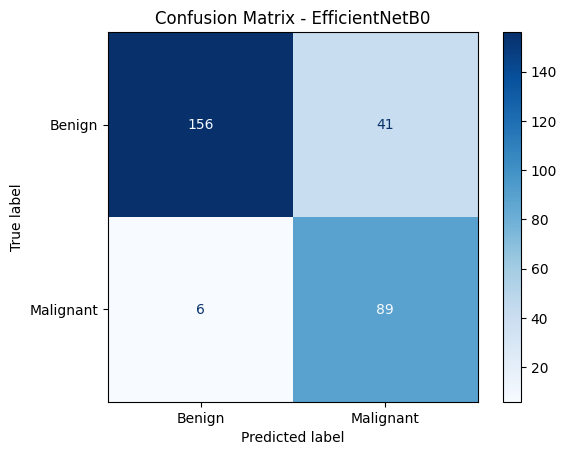

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])

# --- Plot and save the confusion matrix ---
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - EfficientNetB0")
plt.savefig("efficientnet_confusion_matrix.png", bbox_inches='tight')
plt.show()


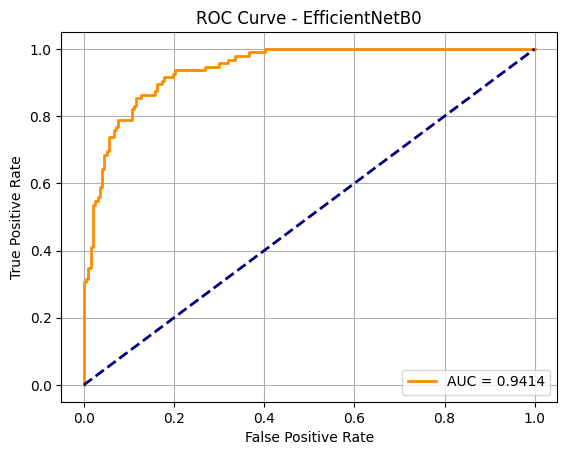

In [ ]:
from sklearn.metrics import roc_curve, auc

# --- Compute ROC curve and AUC ---
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# --- Plot and save the ROC curve ---
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - EfficientNetB0')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("efficientnet_roc_curve.png", bbox_inches='tight')
plt.show()


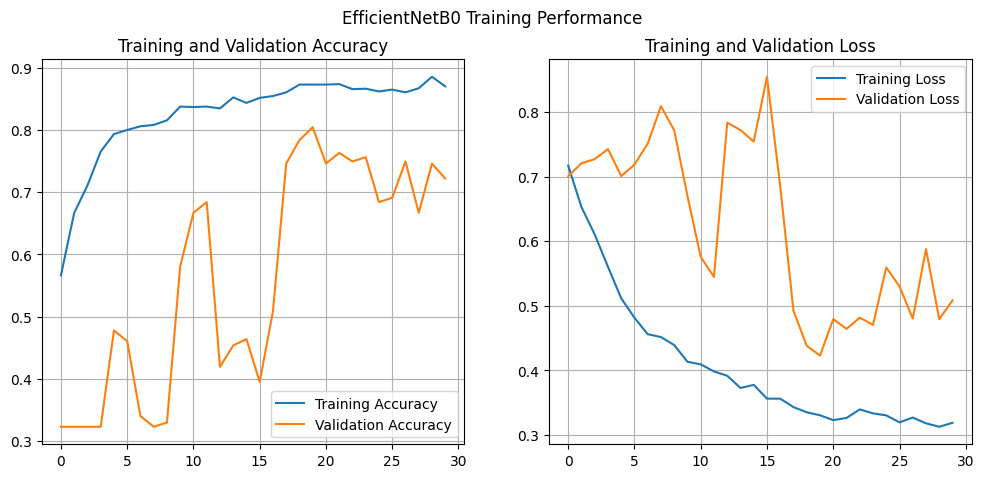

In [ ]:
# --- Assuming 'history' is the output from model.fit ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))


# --- Plot and save training history ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.suptitle('EfficientNetB0 Training Performance')
plt.savefig("efficientnet_training_plot.png", bbox_inches='tight')
plt.show()


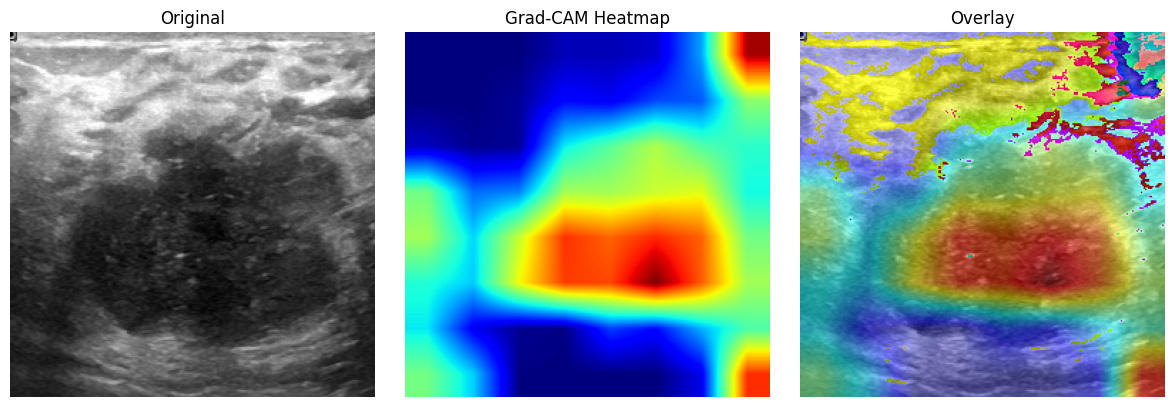

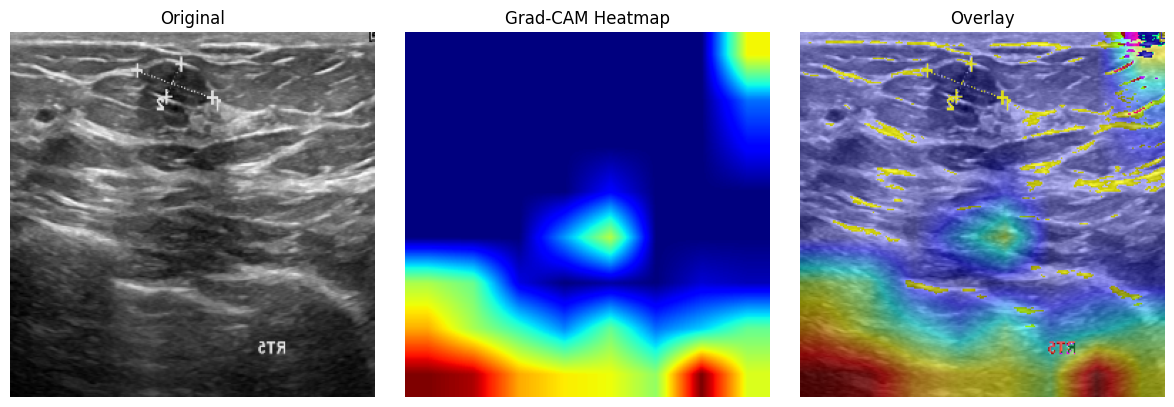

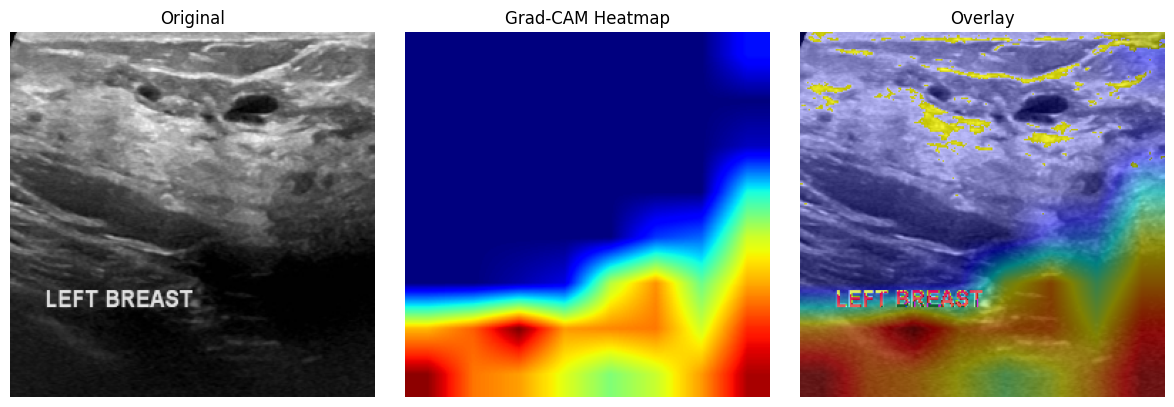

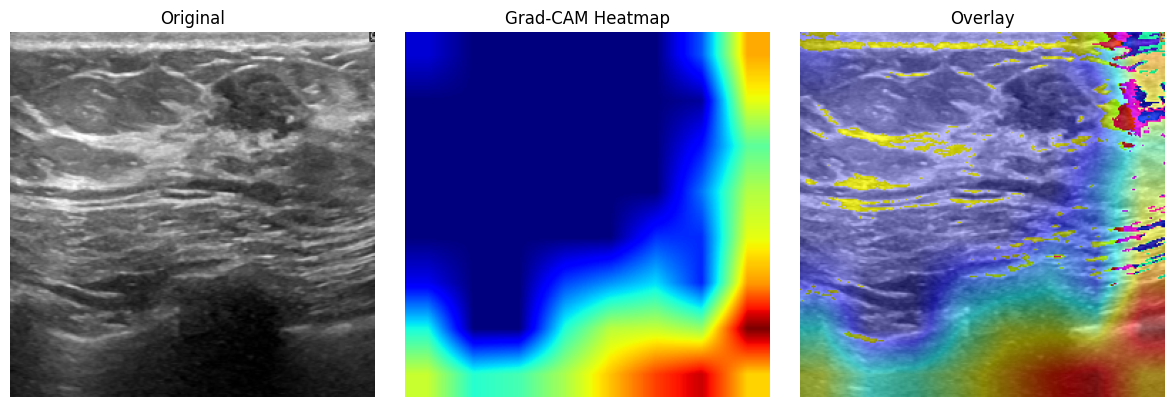

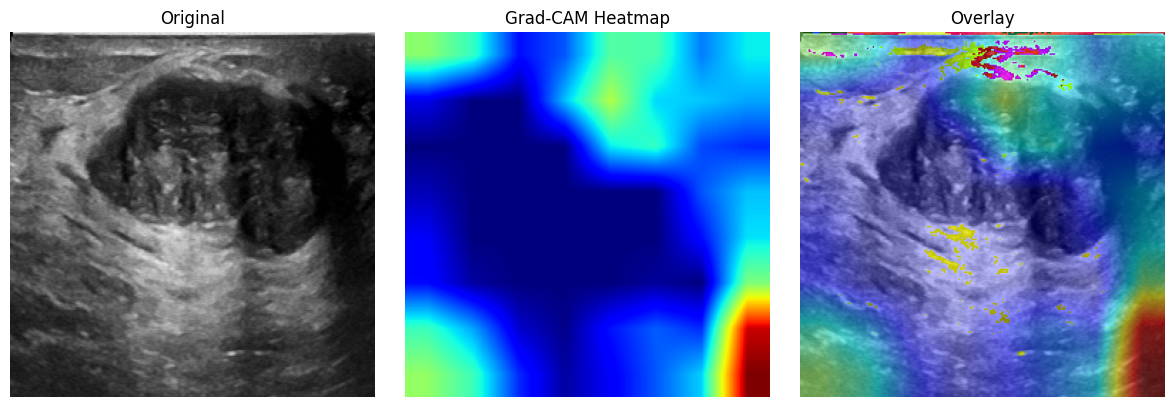

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.applications.efficientnet import preprocess_input

# --- Last convolutional layer in EfficientNetB0 ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model


last_conv_layer_name = "top_conv"

# --- Function to generate Grad-CAM heatmap ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# --- Function to display Grad-CAM results ---
def display_gradcam(original_img, heatmap, alpha=0.5):
    # resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    overlay = heatmap_color * alpha + original_img
    overlay = np.uint8(overlay)

    # plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")
    plt.tight_layout()

    plt.show()


# --- Example: Generate Grad-CAM for sample test images ---
sample_indices = [0, 1, 2, 3, 4]

for idx in sample_indices:
    img = X_test[idx]  # grayscale (256, 256, 1)
    img_rgb = np.repeat(img, 3, axis=-1)
    input_tensor = np.expand_dims(img_rgb, axis=0)
    input_tensor = preprocess_input(input_tensor)

    heatmap = make_gradcam_heatmap(input_tensor, model, last_conv_layer_name)
    original_vis = (img_rgb * 255).astype(np.uint8)
    display_gradcam(original_vis, heatmap)



plt.show()
